In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cardiac_features = pd.read_csv('ECG_Cardiac_Features.csv')
cardiac_features.drop(columns=['Patient_ID'], inplace=True)
fourier_features = pd.read_csv('ECG_Fourier_Transform_Features.csv')
fourier_features.drop(columns=['Patient_ID', 'Label'], inplace=True)
time_features = pd.read_csv('ECG_Time_Features.csv')

merged_features = pd.merge(cardiac_features, fourier_features, on='ecg_id', how='inner')
merged_features = pd.merge(merged_features, time_features, on='ecg_id', how='inner')

merged_features.head()

,ecg_id,Label,Heart Rate,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_pNN50,QRS_duration,PR_duration,RR Interval Mean,...,"value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__fft_coefficient__attr_""abs""__coeff_17","value__fft_coefficient__attr_""abs""__coeff_11",value__lempel_ziv_complexity__bins_10,value__partial_autocorrelation__lag_3,value__partial_autocorrelation__lag_4,"value__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""min""","value__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""var""",value__skewness,value__fourier_entropy__bins_3
0,1,NORM,63.847119,940.000000,17.320508,22.627417,0.000000,141.714286,127.333333,940.000000,...,0.065170,9.043106,74.502545,0.0838,-1.512835,2.218194,0.000088,0.000030,2.905521,0.220352
1,2,NORM,47.838174,1258.285714,82.836615,54.546616,42.857143,174.285714,152.000000,1258.285714,...,0.574924,58.900234,24.919214,0.0786,-1.059925,11.497906,0.000202,0.000027,2.195819,0.079983
2,3,NORM,63.822587,940.444444,20.019435,17.606817,0.000000,130.750000,114.500000,940.444444,...,0.125145,6.973763,100.593283,0.0810,-1.793943,1.794352,0.000112,0.000049,2.827517,0.183378
3,4,NORM,75.152692,800.545455,45.511237,35.185224,9.090909,160.727273,110.000000,800.545455,...,0.169628,29.327653,40.714874,0.0904,-1.299110,3.141033,0.000451,0.000043,0.282202,0.125256
4,5,NORM,66.456900,905.200000,51.018080,57.271284,50.000000,NaN,122.000000,905.200000,...,0.151764,5.776241,79.793704,0.0842,-1.839826,1.745159,0.000152,0.000018,1.634762,0.190068


In [3]:
print(merged_features.columns)
print(merged_features.shape)

Index(['ecg_id', 'Label', 'Heart Rate', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD',
       'HRV_pNN50', 'QRS_duration', 'PR_duration', 'RR Interval Mean',
       'RR Interval SD', 'RR Interval RMSSD', 'RR Interval Min',
       'RR Interval Max', 'QT Interval Mean', 'QT Interval SD',
       'ST Segment Amplitude Mean', 'ST Segment Amplitude SD',
       'ST Segment Duration Mean', 'ST Segment Duration SD',
       'Dominant Frequency', 'Frequency Power Sum', 'Mean Frequency',
       'Spectral Entropy', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5',
       'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12',
       'MFCC_13', 'value__quantile__q_0.9', 'value__quantile__q_0.6',
       'value__quantile__q_0.4', 'value__quantile__q_0.7',
       'value__quantile__q_0.1', 'value__quantile__q_0.8',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2',
       'value__change_quantiles

In [4]:
feature_columns = [col for col in merged_features.columns if col not in ['ecg_id', 'Label']]

for col in feature_columns:
    print(f"{col}: {merged_features[col].isna().sum()} missing values")

Heart Rate: 1 missing values
HRV_MeanNN: 0 missing values
HRV_SDNN: 0 missing values
HRV_RMSSD: 0 missing values
HRV_pNN50: 0 missing values
QRS_duration: 2814 missing values
PR_duration: 3221 missing values
RR Interval Mean: 0 missing values
RR Interval SD: 0 missing values
RR Interval RMSSD: 0 missing values
RR Interval Min: 0 missing values
RR Interval Max: 0 missing values
QT Interval Mean: 198 missing values
QT Interval SD: 198 missing values
ST Segment Amplitude Mean: 186 missing values
ST Segment Amplitude SD: 186 missing values
ST Segment Duration Mean: 186 missing values
ST Segment Duration SD: 186 missing values
Dominant Frequency: 0 missing values
Frequency Power Sum: 0 missing values
Mean Frequency: 0 missing values
Spectral Entropy: 0 missing values
MFCC_1: 0 missing values
MFCC_2: 0 missing values
MFCC_3: 0 missing values
MFCC_4: 0 missing values
MFCC_5: 0 missing values
MFCC_6: 0 missing values
MFCC_7: 0 missing values
MFCC_8: 0 missing values
MFCC_9: 0 missing values
MF

In [5]:
classes = list(merged_features['Label'].unique())

feature_columns = [col for col in merged_features.columns if col not in ['ecg_id', 'Label']]

for col in feature_columns:
    merged_features[col] = merged_features.groupby('Label')[col].transform(
        lambda x: x.fillna(x.mean())
    )

In [6]:
feature_columns = [col for col in merged_features.columns if col not in ['ecg_id', 'Label']]

for col in feature_columns:
    print(f"{col}: {merged_features[col].isna().sum()} missing values")

Heart Rate: 0 missing values
HRV_MeanNN: 0 missing values
HRV_SDNN: 0 missing values
HRV_RMSSD: 0 missing values
HRV_pNN50: 0 missing values
QRS_duration: 0 missing values
PR_duration: 0 missing values
RR Interval Mean: 0 missing values
RR Interval SD: 0 missing values
RR Interval RMSSD: 0 missing values
RR Interval Min: 0 missing values
RR Interval Max: 0 missing values
QT Interval Mean: 0 missing values
QT Interval SD: 0 missing values
ST Segment Amplitude Mean: 0 missing values
ST Segment Amplitude SD: 0 missing values
ST Segment Duration Mean: 0 missing values
ST Segment Duration SD: 0 missing values
Dominant Frequency: 0 missing values
Frequency Power Sum: 0 missing values
Mean Frequency: 0 missing values
Spectral Entropy: 0 missing values
MFCC_1: 0 missing values
MFCC_2: 0 missing values
MFCC_3: 0 missing values
MFCC_4: 0 missing values
MFCC_5: 0 missing values
MFCC_6: 0 missing values
MFCC_7: 0 missing values
MFCC_8: 0 missing values
MFCC_9: 0 missing values
MFCC_10: 0 missing v

In [7]:
X = merged_features[feature_columns]
y = merged_features['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Accuracy: 0.6199711492226319


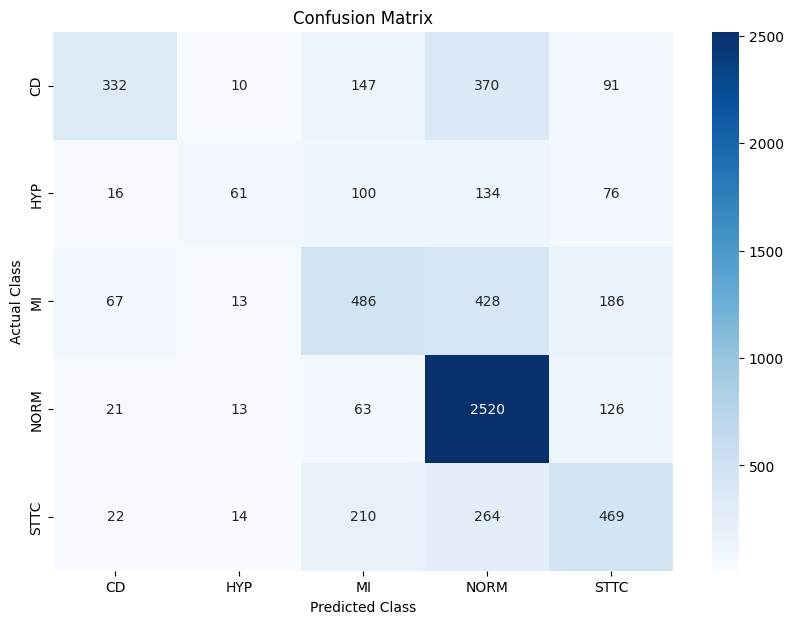

In [8]:
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy_rf)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
labels = sorted(set(y_test) | set(y_pred))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Adding labels, title, and formatting
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix")
plt.show()

In [11]:
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.values.reshape(-1, 1))

X_train_lstm = np.expand_dims(X_train, axis=1)  # Adding a timestep dimension
X_test_lstm = np.expand_dims(X_test, axis=1)

# Define the LSTM model
lstm_model = Sequential([
    Input(shape=(1, X_train.shape[1])),
    LSTM(128, return_sequences=True),
    Dropout(0.4),
    LSTM(64),
    Dropout(0.4),
    Dense(y_train_onehot.shape[1], activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

lstm_model.fit(X_train_lstm, y_train_onehot, epochs=100, batch_size=32, validation_data=(X_test_lstm, y_test_onehot))

lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test_onehot, verbose=0)
print(f"LSTM Test Accuracy: {lstm_accuracy:.2f}")

Epoch 1/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5374 - loss: 1.2726 - val_accuracy: 0.5911 - val_loss: 1.0810
Epoch 2/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5903 - loss: 1.0793 - val_accuracy: 0.5995 - val_loss: 1.0627
Epoch 3/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6034 - loss: 1.0587 - val_accuracy: 0.5988 - val_loss: 1.0518
Epoch 4/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6137 - loss: 1.0381 - val_accuracy: 0.5993 - val_loss: 1.0489
Epoch 5/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6099 - loss: 1.0367 - val_accuracy: 0.6025 - val_loss: 1.0455
Epoch 6/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6068 - loss: 1.0318 - val_accuracy: 0.6075 - val_loss: 1.0372
Epoch 7/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6137 - loss: 1.0223 - val_accuracy: 0.6041 - val_loss: 1.0435
Epoch 8/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6126 - loss: 1.0143 - val_accu